In [1]:
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import glob
import seaborn as sns
import tqdm
import mat4py
from sklearn import metrics
import logomaker
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay
import seqlogo
import scipy
import re
from matplotlib import gridspec
import scipy
from sklearn.metrics import auc, average_precision_score
from collections import OrderedDict
import torch.nn as nn
import torch
import joblib
import torch.nn.functional as F
import torch.optim as optim
import os
%matplotlib notebook

In [2]:
torch.manual_seed(666)
torch.set_deterministic(True)
np.random.seed(666)

In [6]:
# !pip3 install xgboost

In [7]:
import matlab.engine
eng = matlab.engine.start_matlab()

In [8]:
# motif position frequency matrix (PFM) distance
def kc_motif_distance(trimed_true_dimer, trimed_pred_dimer):
    t = matlab.double(trimed_true_dimer.tolist())
    p = matlab.double(trimed_pred_dimer.tolist())
    prof = np.asarray(eng.profalign(p, t)).T
    t = np.asarray(t).T
    p = np.asarray(p).T
    # print(prof)
    # print(p)
    # print(t)
    add_mat = prof[:,:4]
    gap_locus = prof[:,4]
    # print(t.shape, p.shape, add_mat.shape)
    # print(gap_locus)
    total_dist = 0
    max_dist = -1
    t_gap = 0
    p_gap = 0
    for i, lo in enumerate(gap_locus):
        if lo == 0:
            dist = np.sqrt(sum((p[i-p_gap]-t[i-t_gap])**2))
            total_dist += dist
            if dist > max_dist:
                max_dist = dist
        else:
            if i-t_gap >= len(t):
                t_gap += 1
            elif i-p_gap >= len(p):
                p_gap += 1
            elif sum(abs(add_mat[i] - t[i-t_gap])) < sum(abs(add_mat[i] - p[i-p_gap])):
                p_gap += 1
            else:
                t_gap += 1
        # print(max_dist, "p_gap:", p_gap, "t_gap:", t_gap)
    return (total_dist + (p_gap+t_gap)*max_dist)/len(gap_locus)

def get_rev_com_y(seq_mat):
    reversed_mat = seq_mat[::-1].copy()
    for i in range(len(reversed_mat)):
        reversed_mat[i] = np.concatenate((reversed_mat[i][:4][::-1], reversed_mat[i][4:]))
    return reversed_mat

def build_df4logmarker(seq_mat):
    df = pd.DataFrame(columns=['pos', 'A', 'C', 'G', 'T'])
    df['pos'] = np.arange(len(seq_mat))
    df['A'] = seq_mat[:, 0]
    df['C'] = seq_mat[:, 1]
    df['G'] = seq_mat[:, 2]
    df['T'] = seq_mat[:, 3]
    df.set_index(["pos"], inplace=True)
    return df
def get_icDimer(dimer):
    cpm = seqlogo.CompletePm(pfm =(np.round(dimer.T, 3)*1000).astype(int))
    cpm_ic = np.repeat(np.expand_dims(cpm.ic.to_numpy(), axis=1),4, axis=1)*dimer
    return cpm_ic

In [9]:
# DeepMotifSyn generator
class deeper_u_net(nn.Module):
    def __init__(self,device='cuda'):
        super(deeper_u_net, self).__init__()
        self.device = device

        self.encoder1 = nn.Sequential(
            nn.Conv1d(in_channels = 108, out_channels = 64, kernel_size = 4, stride = 1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
        )
        self.encoder2 = nn.Sequential(
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size = 2, stride = 1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
        )
        
        self.decoder1 = nn.Sequential(
            # nn.Conv1d(in_channels = 128*2, out_channels = 128, kernel_size = 1, stride = 1),
            # nn.BatchNorm1d(128),
            # nn.ReLU(),
            nn.ConvTranspose1d(in_channels = 128, out_channels = 64, kernel_size = 2, stride = 1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
        )
        
        self.decoder2 = nn.Sequential(
            nn.ConvTranspose1d(in_channels=64*2, out_channels=64, kernel_size = 4, stride = 1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
        )
        
        self.bottleneck = torch.nn.Sequential(
                            torch.nn.Conv1d(kernel_size=3, in_channels=128, out_channels=256, stride=1),
                            torch.nn.ReLU(),
                            torch.nn.BatchNorm1d(256),
                            torch.nn.Conv1d(kernel_size=1, in_channels=256, out_channels=256, stride=1),
                            torch.nn.ReLU(),
                            torch.nn.BatchNorm1d(256),
                            torch.nn.ConvTranspose1d(in_channels=256, out_channels=128, kernel_size=3, stride=1)
                            )
        
        self.cnn_out = nn.Sequential(
            nn.Conv1d(in_channels=64+8, out_channels=32, kernel_size=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Conv1d(in_channels=32, out_channels=16, kernel_size=1),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Conv1d(in_channels=16, out_channels=4, kernel_size=1),
            nn.BatchNorm1d(4),
            nn.Softmax(dim=1)
        )
        
    def forward(self,x):
        seq_x = x[:,:,:8]
        # family_x = x[:,:,8:]
        # pos_x = torch.arange(1, 36).to(self.device)
        # pos_x = torch.unsqueeze(pos_x, 0).repeat(x.size()[0], 1)
        # pos_embed = self.pos_embedding(pos_x)
        # print(seq_x.size(), pos_embed.size())
        # seq_x = cseq_x # + pos_embed
        # x = torch.cat((seq_x, family_x), 2)
        # print(x.size())
        x = x.permute(0, 2, 1)
        
        en1 = self.encoder1(x)
        en2 = self.encoder2(en1)
        x = self.bottleneck(en2)
        #  print(x.size())
        x = self.decoder1(x)
        x = self.decoder2(torch.cat((x, en1), 1))
        
        seq_x = seq_x.permute(0 ,2, 1)
        # print(x.size(), cseq_x.size())
        
        x = torch.cat((x, seq_x), 1)
        # print(x.size())
        out = self.cnn_out(x)
        # print(x.size())
        return out

In [10]:
# Generating all possible motif pair
# def generate_motif_pair(motif1, motif2)

In [11]:
kc_dimer_info = pd.read_csv("../JiecongData/kc_dimer_info.csv")
homomotif_seq_dict = pkl.load(open("../JiecongData/homodimerMotifDatabase_dict.pkl", "rb"))
motif_seq_dict = pkl.load(open("../JiecongData/motifDatabase_dict.pkl", "rb"))
dimer_seq_dict = pkl.load(open("../JiecongData/dimerMotifDatabase_dict.pkl", "rb"))
dimerfamily_dict = pkl.load(open("../JiecongData/dimerMotifFamily_dict.pkl", "rb"))
map_info = pkl.load(open("../mp_dimer_aligned_info.pkl", "rb"))
found_mp_name, found_mp_family, found_mp_code, true_mp_code, found_mp_dimer_code = pkl.load(open("./generated_motifpairs/found_best_aligned_mp_allFam_correctedFamilyName.pkl", "rb"))
# mp_info_df = pd.read_csv("./generated_motifpairs/generated_motifpairs_with_label_rmDuplicates.csv")

In [12]:
dnameToFamily_dict = pkl.load(open("./manuscript_figures/dimer_name_family_upper_dict.pkl", "rb"))
family_onehot_encode = pkl.load(open("./kc_heterodimer_family_all614dimers_upper_oneHotDict.pkl", "rb"))

In [13]:
dimer_familly_mpCase_dict = pkl.load(open("./deepMotifSyn_pipline/dimerMotif_87family_feaures_dict.pkl", "rb"))

In [38]:
# mp_data = pkl.load(open("./leave_one_MP_out_generative_dimer_dedup/generated_mp_features_with_label_dedup.pkl", "rb"))

In [39]:
# nonSeq_features, seq_features, labels, family_names, dimer_names = mp_data

In [40]:
# seq_features.shape

In [14]:
FLI1_pfm = motif_seq_dict['FLI1']
FOXI1_pfm =  motif_seq_dict['FOXI1']

In [15]:
len(FLI1_pfm), len(FOXI1_pfm)

(14, 7)

In [16]:
# try:
#     motif1_seq = motif_seq_dict[motif1_name]
# except:
#     motif1_seq = homomotif_seq_dict[motif1_name]
# try:
#     motif2_seq = motif_seq_dict[motif2_name]
# except:
#     motif2_seq = homomotif_seq_dict[motif2_name]

In [17]:
motif1 = FLI1_pfm
motif2 = FOXI1_pfm

In [18]:
def get_possible_motifpair(name, motif1, motif2):
    generative_mp_info = []
    possible_mp_code = []
    max_mp_len = 35
    
    for case_i in range(1, 5):
        if case_i == 1:
            m1 = motif1.copy()
            m2 = motif2.copy()
        elif case_i == 2:
            m1 = motif2.copy()
            m2 = motif1.copy()
        elif case_i == 3:
            m1 = get_rev_com_y(motif2).copy()
            m2 = motif1.copy()
        else:
            m1 = motif1.copy()
            m2 = get_rev_com_y(motif2).copy()
        m1_len = len(m1)
        m2_len = len(m2)
        overlap_len=None
        for m1_si in range(max_mp_len):
            m1_ei = m1_si + m1_len
            if m1_ei >= max_mp_len:
                continue
            for m2_si in range(m1_si, max_mp_len):
                m2_ei = m2_si + m2_len
                if m2_ei >= max_mp_len:
                    continue
                m1_code = np.zeros((35, 4))
                m2_code = np.zeros((35, 4))
                m1_code[m1_si:m1_ei] = m1
                m2_code[m2_si:m2_ei] = m2
                mp_code = np.concatenate([m1_code, m2_code], axis=-1)
                
                if m2_si >= m1_ei:
                    overlap_len = -(m2_si - m1_ei)
                else:
                    overlap_len = sum(mp_code.sum(-1) > 1.1)
        
                possible_mp_code.append(mp_code)
                #print(case_i, overlap_len)
                generative_mp_info.append([case_i, overlap_len, m1_si, m2_si])
    generative_mp_info = np.array(generative_mp_info)
    df = pd.DataFrame(columns=['dimer_name', 'orientation_case', 'overlapping_len', 'm1_start_idx', 'm2_start_idx'])
    df['dimer_name']  = [name] * len(generative_mp_info)
    df['orientation_case'] = generative_mp_info[:, 0]
    df['overlapping_len'] = generative_mp_info[:, 1]
    df['m1_start_idx'] = generative_mp_info[:, 2]
    df['m2_start_idx'] = generative_mp_info[:, 3]
    return df, np.array(possible_mp_code)

possible_mp_df, possible_mp_code = get_possible_motifpair('FLI1_FOXI1',FLI1_pfm, FOXI1_pfm)    

In [19]:
net = deeper_u_net().cuda()
net.eval()
checkpoint = torch.load('./leave.one.motifpair.out.uNetAdv.crxvalidate\\fold_FOX_ETS-FLI1_FOXI1-FLI1_FOXI1_2-FLI1_FOXI1_3-FLI1_FOXI1_4_best_u_net_mp_checkpoint.pt')
net.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [20]:
family_code = family_onehot_encode[dnameToFamily_dict['FLI1_FOXI1']][np.newaxis,:]
family_code.shape, possible_mp_code.shape

((1, 1, 100), (1218, 35, 8))

In [21]:
family_code = np.repeat(family_code, 35, axis=1)
family_code = np.repeat(family_code, len(possible_mp_code), axis=0)

In [22]:
possible_mp_code_witFAM = np.concatenate([possible_mp_code, family_code], axis=-1)

In [23]:
possible_mp_code_witFAM.shape

(1218, 35, 108)

In [24]:
# generative heterodimeric motif
net.eval()
with torch.no_grad():
    X_input = torch.from_numpy(possible_mp_code_witFAM).cuda().float()
    pred_dimer = net(X_input).cpu().detach().numpy()

In [25]:
# get information content 
pred_dimer.shape

(1218, 4, 35)

In [27]:
# def get_icDimer_only(dimer):
#     cpm = seqlogo.CompletePm(pfm =(np.round(dimer.T, 3)*1000).astype(int))
#     cpm_ic = np.repeat(np.expand_dims(cpm.ic.to_numpy(), axis=1),4, axis=1)*dimer.T
#     return cpm_ic
# pred_dimer_ic = np.array(Parallel(n_jobs=15, verbose=1)(delayed(get_icDimer_only)(d) for d in pred_dimer))

In [31]:
from joblib import Parallel, delayed
def get_icDimer(dimer):
    cpm = seqlogo.CompletePm(pfm =(np.round(dimer.T, 6)*1e6).astype(int))
    cpm_ic = np.repeat(np.expand_dims(cpm.ic.to_numpy(), axis=1),4, axis=1)
    # print(cpm_ic.shape, dimer.shape)
    return cpm_ic*dimer, cpm.ic.to_numpy()

In [32]:
# pred_dimer_ic = np.array(pred_dimer_ic)

In [33]:
overlap_len_dict = {}
onehot_idx = 0
for i in range(-20, 21):
    overlap_len_dict[i] = onehot_idx
    onehot_idx+=1
    
def encode_aligned_features(olen, case):
    case_code = np.zeros(4)
    olen_code = np.zeros(41)
    case_code[case-1] += 1
    olen_code[overlap_len_dict[olen]] += 1
    return case_code, olen_code

In [34]:
possible_mp_df

,dimer_name,orientation_case,overlapping_len,m1_start_idx,m2_start_idx
0,FLI1_FOXI1,1,7,0,0
1,FLI1_FOXI1,1,7,0,1
2,FLI1_FOXI1,1,7,0,2
3,FLI1_FOXI1,1,7,0,3
4,FLI1_FOXI1,1,7,0,4
...,...,...,...,...,...
1213,FLI1_FOXI1,4,7,20,23
1214,FLI1_FOXI1,4,7,20,24
1215,FLI1_FOXI1,4,7,20,25
1216,FLI1_FOXI1,4,7,20,26


In [36]:
# def build_features
possible_mp_784feaures = []
for idx, row in tqdm.tqdm(possible_mp_df.iterrows()):
    # dimer_idx = row['generated_mp_idx']
    # print(idx)
    
    ol_len = row['overlapping_len']
    motif1 = possible_mp_code[idx, :, :4]
    motif2 = possible_mp_code[idx, :, 4:8]
    for i, b in enumerate(motif1):
        if sum(b) < 0.3:
            motif1[i] = np.array([0.25, 0.25, 0.25, 0.25])
    for i, b in enumerate(motif2):
        if sum(b) < 0.3:
            motif2[i] = np.array([0.25, 0.25, 0.25, 0.25])
    
    overlapping_position = np.zeros(35)
    motif1_ic, ic1 = get_icDimer(motif1)
    motif2_ic, ic2 = get_icDimer(motif2)
    overlap_locus = np.logical_and(motif2_ic.sum(-1)>10e-7,motif1_ic.sum(-1)>10e-7)
    overlap_len = sum(overlap_locus)
#   print(overlap_len, ol_len)
# 
    
    motif1_ol = np.zeros((18, 4))-1
    mp_ol_diff = np.zeros((18))-1
    motif2_ol = np.zeros((18, 4))-1 
    mp_ol_sum = np.zeros((18, 4))-1
    motif1_ol_ic = np.zeros(18) - 1
    motif2_ol_ic = np.zeros(18) - 1
    mp_ic_diff = np.zeros(18) - 1
    
    if overlap_len > 0:
        # overlap_seq_withIC
        #  print(motif1_ic.shape)
        motif1_ol[:overlap_len] = motif1_ic[overlap_locus]
        motif2_ol[:overlap_len] = motif2_ic[overlap_locus]
        # euclidean distance of seq with IC
        mp_ol_diff[:overlap_len] = np.sqrt(((motif1_ic[overlap_locus] - motif2_ic[overlap_locus])**2).sum(-1))
        # overlap_seq_sum
        mp_ol_sum[:overlap_len] = motif1_ic[overlap_locus] + motif2_ic[overlap_locus]
        # overlap ic and its mse
        motif1_ol_ic[:overlap_len] = ic1[overlap_locus]
        motif2_ol_ic[:overlap_len] = ic2[overlap_locus]
        mp_ic_diff[:overlap_len] = np.sqrt((ic1[overlap_locus] - ic2[overlap_locus])**2)
        # AGCT stats
        motif1_overlap_base = motif1_ic[overlap_locus,:].sum(0)
        motif2_overlap_base = motif2_ic[overlap_locus,:].sum(0)
    
    overlap_feats = np.concatenate([motif1_ol.flatten(), motif2_ol.flatten(), motif1_ol_ic, motif1_ol_ic, mp_ol_diff.flatten(), mp_ol_sum.flatten(), mp_ic_diff, motif2_overlap_base.flatten(), motif1_overlap_base.flatten()])
    seq_feats = np.concatenate([motif1_ic.flatten(), motif2_ic.flatten(), ic1.flatten(), ic2.flatten()])
    feats = np.concatenate([overlap_feats, seq_feats])
    # features.append(feats)
    
    # overlap, spacing features
    dname = row['dimer_name']
    dimerFam = dnameToFamily_dict[dname]
    ol_len = row['overlapping_len']
    #  dimerFam = row['family_name_upper']
    # dimer_idx = row['generated_mp_idx']
    case_fam, olen_fam, _, _= dimer_familly_mpCase_dict[dimerFam]
    case_gmp, olen_gmp = encode_aligned_features(row['overlapping_len'], row['orientation_case'])
    case_mul, olen_mul = case_fam*case_gmp, olen_fam*olen_gmp
    # mul_sum = [sum(case_mul), sum(olen_mul), sum(m1_sid_mul), sum(m2_sid_mul)]
    mul_sum = [sum(case_mul), sum(olen_mul)]
    total_sum = [sum(mul_sum)]
    # print(case_gmp, olen_gmp, row['overlapping_len'])
    # print(sum(case_mul), sum(olen_mul), sum(mul_sum))
    generative_seq_ic, _ = get_icDimer(pred_dimer[idx].T)
    generative_seq_ic = generative_seq_ic.flatten()
    feat_784 = np.concatenate([feats, case_fam, olen_fam, case_gmp, olen_gmp, case_mul, olen_mul, mul_sum, total_sum])
    possible_mp_784feaures.append(feat_784)
    # np.save("./generative_seq_features/" + dimer_idx + "_646features", feats)
    # print(motif1_overlap, motif2_overlap)
    # print(ic1_overlap, ic2_overlap)
    # print(mp_ic_diff)
    # break
possible_mp_784feaures = np.array(possible_mp_784feaures)

1218it [00:13, 93.25it/s]


In [37]:
possible_mp_784feaures.shape, pred_dimer.shape

((1218, 784), (1218, 4, 35))

In [38]:
possible_mp_924feaures = np.concatenate([possible_mp_784feaures, pred_dimer.reshape(len(pred_dimer), -1)], axis=-1) # np.concatenate([possible_mp_784feaures, pred_dimer_ic.reshape(len(pred_dimer_ic), -1)], axis=-1)

In [39]:
possible_mp_924feaures.shape

(1218, 924)

In [40]:
# XGboost
xgboost_evaluator = joblib.load("./deepMotifSyn_pipline/fold_FLI1_FOXI1_XGBoost_bestHyper_924features.joblib")

In [41]:
possible_mp_score = xgboost_evaluator.predict_proba(possible_mp_924feaures)

In [42]:
possible_mp_df['score'] = possible_mp_score[:, 1]

In [43]:
# possible_mp_df

In [85]:
sorted_df = possible_mp_df.sort_values(by='score', ascending=False)

In [86]:
sorted_df['rank'] = np.arange(1, len(sorted_df)+1)

In [46]:
# possible_mp_df[~possible_mp_df['matched_true_dimer'].isna()]

In [101]:
# find best matched
found_matched_dict = {}
found_matched_mmd_dict = {}
true_dimers = ['FLI1_FOXI1', 'FLI1_FOXI1_2', 'FLI1_FOXI1_3', 'FLI1_FOXI1_4']
for tdimer in true_dimers:
    print(tdimer)
    min_diff = np.inf
    matched_idx = None
    tdimer_code = found_mp_dimer_code[found_mp_name == tdimer][0].copy()
    for tidx, b in enumerate(tdimer_code):
        if b.sum() < 0.3:
            end_idx = tidx
            tdimer_code[tidx] = np.array([0.25, 0.25, 0.25, 0.25])
    trim_tdimer_code = tdimer_code[:end_idx]
    for mp_idx , mp_code in enumerate(pred_dimer):
        mp_code = mp_code.T
        trim_pdimer_code = mp_code[:end_idx]
        # print(trim_tdimer_code.shape, trim_pdimer_code.shape)
        tdiff = kc_motif_distance(trim_tdimer_code.T, trim_pdimer_code.T)
        if tdiff < min_diff:
            matched_idx = mp_idx
            min_diff = tdiff
    found_matched_dict[tdimer] = matched_idx
    found_matched_mmd_dict[tdimer] = min_diff
for dname in found_matched_dict.keys():
    possible_mp_df.loc[found_matched_dict[dname], 'matched_true_dimer_min_mmd'] = dname + ":" + str(found_matched_mmd_dict[dname])

FLI1_FOXI1
FLI1_FOXI1_2
FLI1_FOXI1_3
FLI1_FOXI1_4


In [102]:
possible_mp_df[~possible_mp_df['matched_true_dimer_min_mmd'].isna()]

,dimer_name,orientation_case,overlapping_len,m1_start_idx,m2_start_idx,score,matched_true_dimer_min_mmd
1,FLI1_FOXI1,1,7,0,1,0.009355,FLI1_FOXI1:0.27985295610586547
382,FLI1_FOXI1,2,3,0,4,0.260644,FLI1_FOXI1_3:0.19067830288900015
613,FLI1_FOXI1,3,3,0,4,0.453138,FLI1_FOXI1_4:0.18123857682149702
846,FLI1_FOXI1,4,7,0,6,0.188519,FLI1_FOXI1_2:0.1650014655433748


In [108]:
possible_mp_df.describe()

,orientation_case,overlapping_len,m1_start_idx,m2_start_idx,score
count,1218.000000,1218.000000,1218.000000,1218.000000,1218.000000
mean,2.500000,1.942529,7.471264,15.908046,0.001802
std,1.221722,5.248624,5.504274,6.420342,0.017281
min,1.000000,-13.000000,0.000000,0.000000,0.000019
25%,1.000000,-2.000000,3.000000,11.000000,0.000042
50%,2.500000,3.000000,7.000000,16.000000,0.000079
75%,4.000000,7.000000,12.000000,20.000000,0.000122
max,4.000000,7.000000,20.000000,27.000000,0.453138


In [206]:
# # find the matched alignment
# found_matched_dict = {}
# for tdimer in true_dimers:
#     min_diff = np.inf
#     matched_idx = None
#     tdimer_code = found_mp_dimer_code[found_mp_name == tdimer][0].copy()
#     for tidx, b in enumerate(tdimer_code):
#         if b.sum() < 0.3:
#             tdimer_code[tidx] = np.array([0.25, 0.25, 0.25, 0.25])
#     for mp_idx , mp_code in enumerate(possible_mp_code):
#         tdiff = (np.abs(mp_code[:, :4] - tdimer_code)).sum()+(np.abs(mp_code[:, 4:] - tdimer_code)).sum()
#         if tdiff < min_diff:
#             matched_idx = mp_idx
#             min_diff = tdiff
#     found_matched_dict[tdimer] = matched_idx
# for dname in found_matched_dict.keys():
#     possible_mp_df.loc[found_matched_dict[dname], 'matched_true_dimer'] = dname

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


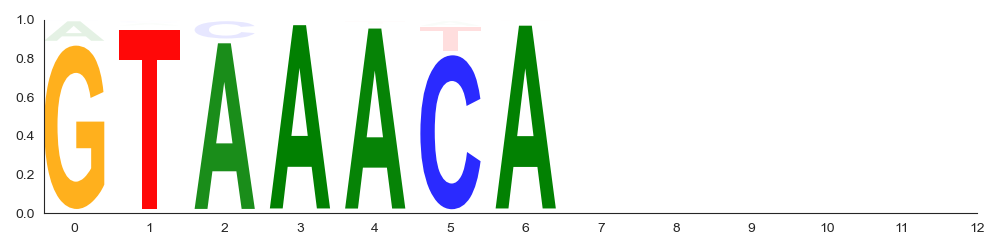

In [70]:

sns.set_style("white")

FLI1_pfm = motif_seq_dict['FLI1']
FOXI1_pfm =  motif_seq_dict['FOXI1']
df = build_df4logmarker(FLI1_pfm)
logo = logomaker.Logo(df,
                         width=.8,
                         vpad=.05,
                         fade_probabilities=True,
                         stack_order='small_on_top')

# plt.title('FLI1')
logo.ax.set_xticks(range(len(df)))
plt.tight_layout()
sns.despine(left=False)
df = build_df4logmarker(FOXI1_pfm)
logo = logomaker.Logo(df,
                         width=.8,
                         vpad=.05,
                         fade_probabilities=True,
                         stack_order='small_on_top')
logo.ax.set_xticks(range(13))
# plt.title('FOXI1')
plt.tight_layout()
sns.despine(left=False)

In [91]:
tpfm = found_mp_dimer_code[found_mp_name == 'FLI1_FOXI1'][0]
for i in tpfm :
    s = ""
    for j in i:
        s += str(j) + " "
    print(s)

0.25 0.25 0.25 0.25 
0.25 0.25 0.25 0.25 
0.25 0.25 0.25 0.25 
0.25 0.25 0.25 0.25 
0.237446809 0.001702128 0.695319149 0.065531915 
0.970308789 0.001187648 0.024940618 0.003562945 
1.0 0.0 0.0 0.0 
1.0 0.0 0.0 0.0 
0.954439252 0.023364486 0.022196262 0.0 
0.007255139 0.987908102 0.004836759 0.0 
0.003550296 0.966863905 0.029585799 0.0 
0.0 0.0 0.995127893 0.004872107 
0.86 0.002105263 0.137894737 0.0 
0.861814346 0.0 0.0 0.138185654 
0.775142315 0.072106262 0.007590133 0.14516129 
0.285189718 0.690330477 0.003671971 0.020807834 
-1.0 -1.0 -1.0 -1.0 
-1.0 -1.0 -1.0 -1.0 
-1.0 -1.0 -1.0 -1.0 
-1.0 -1.0 -1.0 -1.0 
-1.0 -1.0 -1.0 -1.0 
-1.0 -1.0 -1.0 -1.0 
-1.0 -1.0 -1.0 -1.0 
-1.0 -1.0 -1.0 -1.0 
-1.0 -1.0 -1.0 -1.0 
-1.0 -1.0 -1.0 -1.0 
-1.0 -1.0 -1.0 -1.0 
-1.0 -1.0 -1.0 -1.0 
-1.0 -1.0 -1.0 -1.0 
-1.0 -1.0 -1.0 -1.0 
-1.0 -1.0 -1.0 -1.0 
-1.0 -1.0 -1.0 -1.0 
-1.0 -1.0 -1.0 -1.0 
-1.0 -1.0 -1.0 -1.0 
-1.0 -1.0 -1.0 -1.0 


<IPython.core.display.Javascript object>


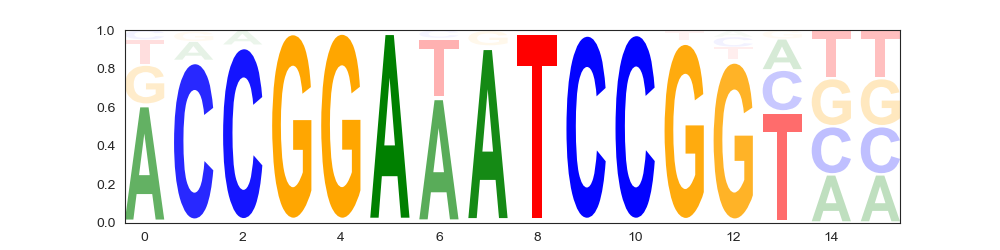

<IPython.core.display.Javascript object>


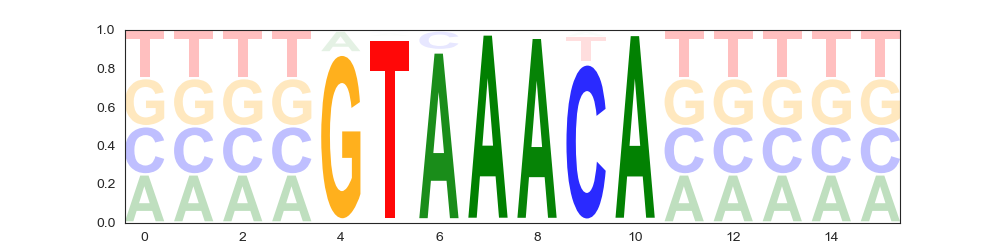

<IPython.core.display.Javascript object>


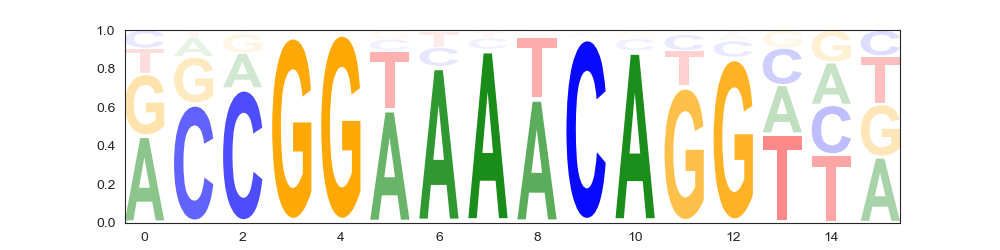

<IPython.core.display.Javascript object>


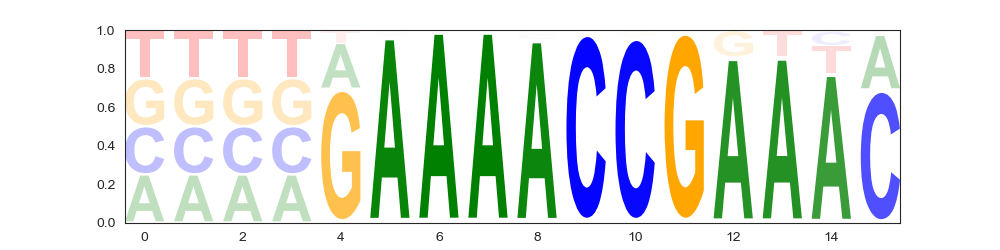

In [96]:
mp_idx = 4
tdimer = 'FLI1_FOXI1'
motif1 = possible_mp_code[mp_idx,:,:4]
motif2 = possible_mp_code[mp_idx,:,4:]
tdimer = found_mp_dimer_code[found_mp_name == tdimer][0]
pdimer = pred_dimer[4].T
for idx, b in enumerate(motif1):
    if sum(b) < 0.3:
        motif1[idx] = np.array([0.25, 0.25, 0.25, 0.25])
for idx, b in enumerate(motif2):
    if sum(b) < 0.3:
        motif2[idx] = np.array([0.25, 0.25, 0.25, 0.25])
for idx, b in enumerate(tdimer):
    if sum(b) < 0.3:
        tdimer[idx] = np.array([0.001, 0.001, 0.001, 0.001])
trim_len = 16
motif1_df = build_df4logmarker(motif1[:trim_len])
logo = logomaker.Logo(motif1_df,
                         width=.8,
                         vpad=.05,
                         fade_probabilities=True,
                         stack_order='small_on_top')
motif2_df = build_df4logmarker(motif2[:trim_len])
logo = logomaker.Logo(motif2_df,
                         width=.8,
                         vpad=.05,
                         fade_probabilities=True,
                         stack_order='small_on_top')
pred_dimer_dimer_df = build_df4logmarker(pdimer[:trim_len])
logo = logomaker.Logo(pred_dimer_dimer_df,
                         width=.8,
                         vpad=.05,
                         fade_probabilities=True,
                         stack_order='small_on_top')

true_dimer_df = build_df4logmarker(tdimer[:trim_len])
logo = logomaker.Logo(true_dimer_df,
                         width=.8,
                         vpad=.05,
                         fade_probabilities=True,
                         stack_order='small_on_top')

<IPython.core.display.Javascript object>


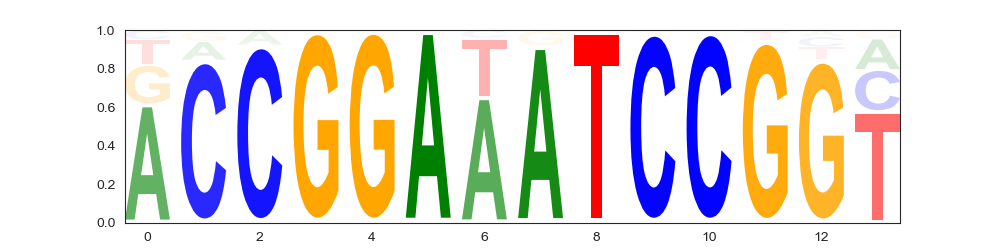

<IPython.core.display.Javascript object>


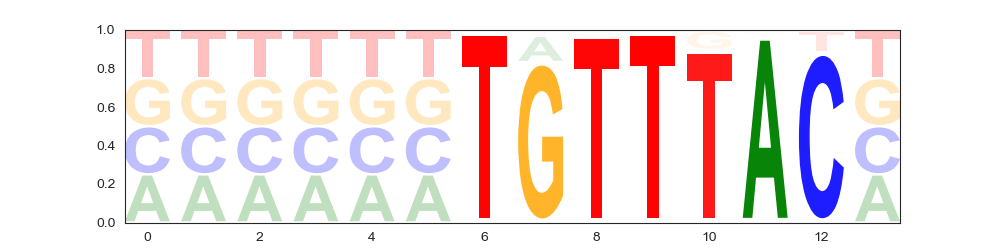

<IPython.core.display.Javascript object>


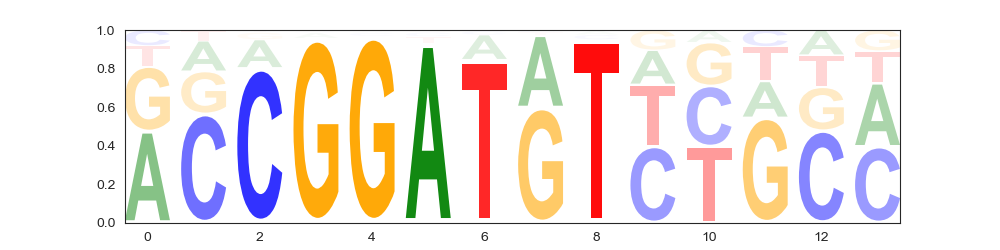

<IPython.core.display.Javascript object>


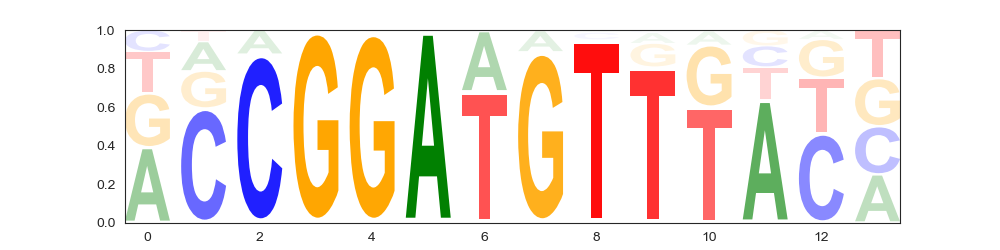

In [75]:
mp_idx = 846
tdimer = 'FLI1_FOXI1_2'
motif1 = possible_mp_code[mp_idx,:,:4]
motif2 = possible_mp_code[mp_idx,:,4:]
tdimer = found_mp_dimer_code[found_mp_name == tdimer][0]
pdimer = pred_dimer[mp_idx].T
for idx, b in enumerate(motif1):
    if sum(b) < 0.3:
        motif1[idx] = np.array([0.25, 0.25, 0.25, 0.25])
for idx, b in enumerate(motif2):
    if sum(b) < 0.3:
        motif2[idx] = np.array([0.25, 0.25, 0.25, 0.25])
for idx, b in enumerate(tdimer):
    if sum(b) < 0.3:
        tdimer[idx] = np.array([0.001, 0.001, 0.001, 0.001])
trim_len = 14
motif1_df = build_df4logmarker(motif1[:trim_len])
logo = logomaker.Logo(motif1_df,
                         width=.8,
                         vpad=.05,
                         fade_probabilities=True,
                         stack_order='small_on_top')
motif2_df = build_df4logmarker(motif2[:trim_len])
logo = logomaker.Logo(motif2_df,
                         width=.8,
                         vpad=.05,
                         fade_probabilities=True,
                         stack_order='small_on_top')
pred_dimer_dimer_df = build_df4logmarker(pdimer[:trim_len])
logo = logomaker.Logo(pred_dimer_dimer_df,
                         width=.8,
                         vpad=.05,
                         fade_probabilities=True,
                         stack_order='small_on_top')

true_dimer_df = build_df4logmarker(tdimer[:trim_len])
logo = logomaker.Logo(true_dimer_df,
                         width=.8,
                         vpad=.05,
                         fade_probabilities=True,
                         stack_order='small_on_top')

<IPython.core.display.Javascript object>


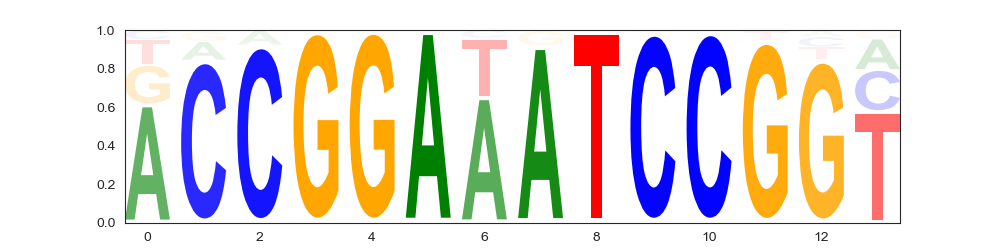

<IPython.core.display.Javascript object>


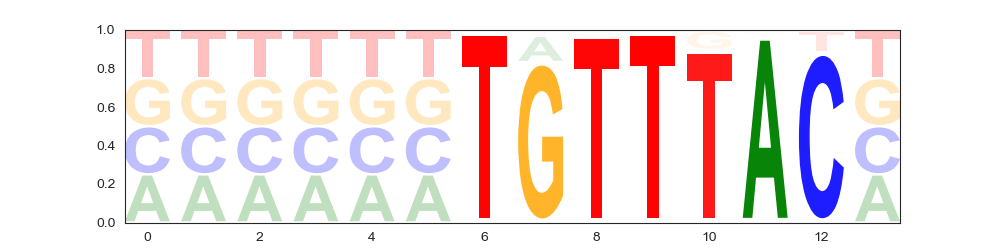

<IPython.core.display.Javascript object>


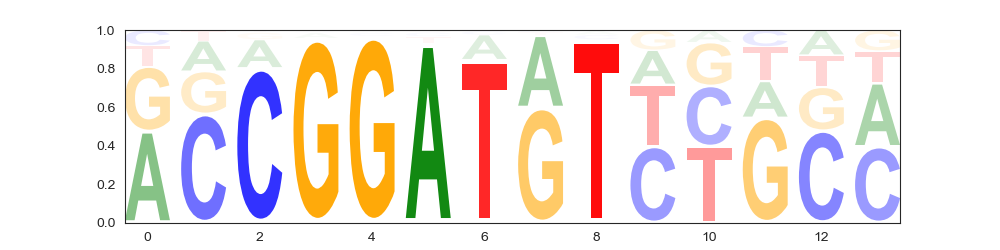

<IPython.core.display.Javascript object>

In [79]:
mp_idx = 846
tdimer = 'FLI1_FOXI1_2'
motif1 = possible_mp_code[mp_idx,:,:4]
motif2 = possible_mp_code[mp_idx,:,4:]
tdimer = found_mp_dimer_code[found_mp_name == tdimer][0]
pdimer = pred_dimer[mp_idx].T
for idx, b in enumerate(motif1):
    if sum(b) < 0.3:
        motif1[idx] = np.array([0.25, 0.25, 0.25, 0.25])
for idx, b in enumerate(motif2):
    if sum(b) < 0.3:
        motif2[idx] = np.array([0.25, 0.25, 0.25, 0.25])
for idx, b in enumerate(tdimer):
    if sum(b) < 0.3:
        tdimer[idx] = np.array([0.001, 0.001, 0.001, 0.001])
motif1_df = build_df4logmarker(motif1)
trim_len = 14
motif1_df = build_df4logmarker(motif1[:trim_len])
logo = logomaker.Logo(motif1_df,
                         width=.8,
                         vpad=.05,
                         fade_probabilities=True,
                         stack_order='small_on_top')
motif2_df = build_df4logmarker(motif2[:trim_len])
logo = logomaker.Logo(motif2_df,
                         width=.8,
                         vpad=.05,
                         fade_probabilities=True,
                         stack_order='small_on_top')
pred_dimer_dimer_df = build_df4logmarker(pdimer[:trim_len])
logo = logomaker.Logo(pred_dimer_dimer_df,
                         width=.8,
                         vpad=.05,
                         fade_probabilities=True,
                         stack_order='small_on_top')

true_dimer_df = build_df4logmarker(tdimer[:trim_len])
logo = logomaker.Logo(true_dimer_df,
                         width=.8,
                         vpad=.05,
                         fade_probabilities=True,
                         stack_order='small_on_top')

<IPython.core.display.Javascript object>


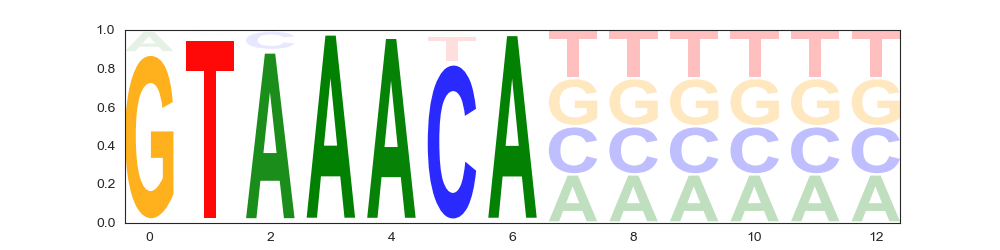

<IPython.core.display.Javascript object>


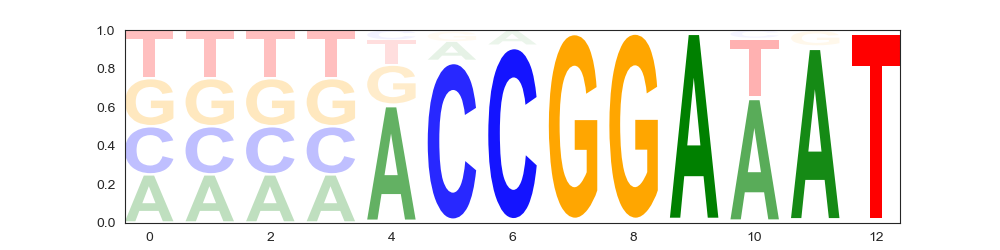

<IPython.core.display.Javascript object>


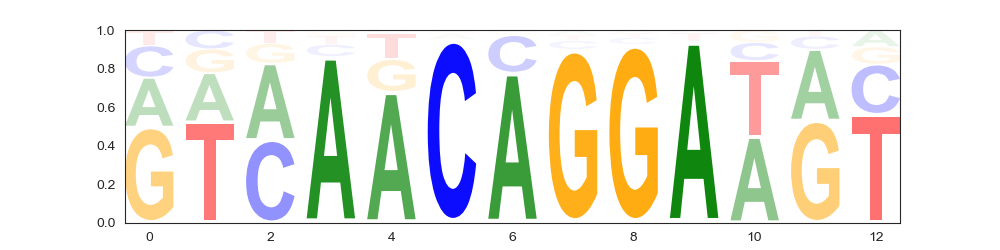

<IPython.core.display.Javascript object>


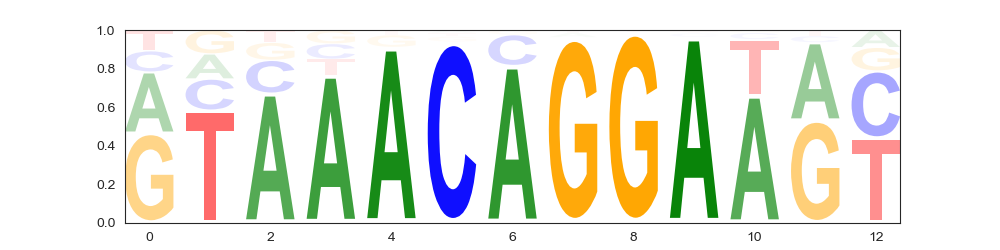

In [80]:
mp_idx = 382
tdimer = 'FLI1_FOXI1_3'
motif1 = possible_mp_code[mp_idx,:,:4]
motif2 = possible_mp_code[mp_idx,:,4:]
tdimer = found_mp_dimer_code[found_mp_name == tdimer][0]
pdimer = pred_dimer[mp_idx].T
for idx, b in enumerate(motif1):
    if sum(b) < 0.3:
        motif1[idx] = np.array([0.25, 0.25, 0.25, 0.25])
for idx, b in enumerate(motif2):
    if sum(b) < 0.3:
        motif2[idx] = np.array([0.25, 0.25, 0.25, 0.25])
for idx, b in enumerate(tdimer):
    if sum(b) < 0.3:
        tdimer[idx] = np.array([0.001, 0.001, 0.001, 0.001])
trim_len = 13
motif1_df = build_df4logmarker(motif1[:trim_len])
logo = logomaker.Logo(motif1_df,
                         width=.8,
                         vpad=.05,
                         fade_probabilities=True,
                         stack_order='small_on_top')
motif2_df = build_df4logmarker(motif2[:trim_len])
logo = logomaker.Logo(motif2_df,
                         width=.8,
                         vpad=.05,
                         fade_probabilities=True,
                         stack_order='small_on_top')
pred_dimer_dimer_df = build_df4logmarker(pdimer[:trim_len])
logo = logomaker.Logo(pred_dimer_dimer_df,
                         width=.8,
                         vpad=.05,
                         fade_probabilities=True,
                         stack_order='small_on_top')

true_dimer_df = build_df4logmarker(tdimer[:trim_len])
logo = logomaker.Logo(true_dimer_df,
                         width=.8,
                         vpad=.05,
                         fade_probabilities=True,
                         stack_order='small_on_top')

<IPython.core.display.Javascript object>


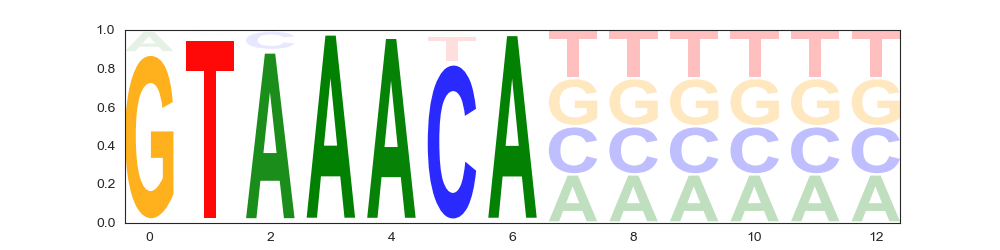

<IPython.core.display.Javascript object>


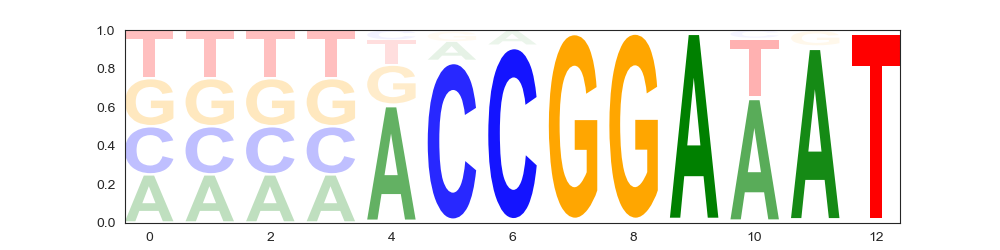

<IPython.core.display.Javascript object>


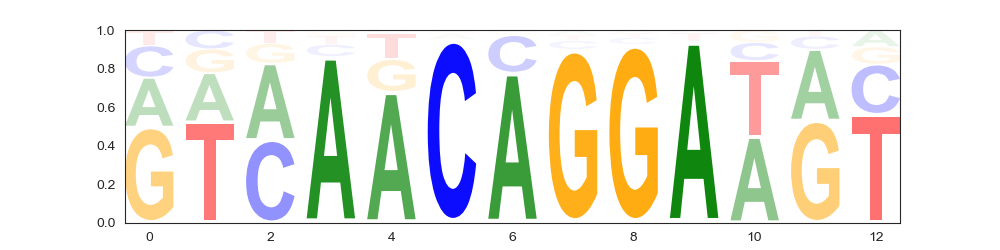

<IPython.core.display.Javascript object>


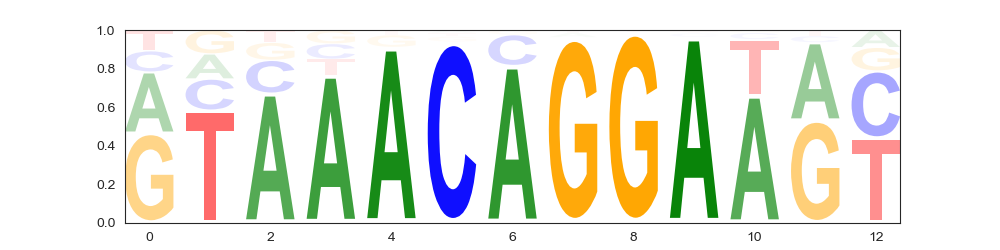

In [81]:
mp_idx = 382
tdimer = 'FLI1_FOXI1_3'
motif1 = possible_mp_code[mp_idx,:,:4]
motif2 = possible_mp_code[mp_idx,:,4:]
tdimer = found_mp_dimer_code[found_mp_name == tdimer][0]
pdimer = pred_dimer[mp_idx].T
for idx, b in enumerate(motif1):
    if sum(b) < 0.3:
        motif1[idx] = np.array([0.25, 0.25, 0.25, 0.25])
for idx, b in enumerate(motif2):
    if sum(b) < 0.3:
        motif2[idx] = np.array([0.25, 0.25, 0.25, 0.25])
for idx, b in enumerate(tdimer):
    if sum(b) < 0.3:
        tdimer[idx] = np.array([0.001, 0.001, 0.001, 0.001])
motif1_df = build_df4logmarker(motif1)
trim_len = 13
motif1_df = build_df4logmarker(motif1[:trim_len])
logo = logomaker.Logo(motif1_df,
                         width=.8,
                         vpad=.05,
                         fade_probabilities=True,
                         stack_order='small_on_top')
motif2_df = build_df4logmarker(motif2[:trim_len])
logo = logomaker.Logo(motif2_df,
                         width=.8,
                         vpad=.05,
                         fade_probabilities=True,
                         stack_order='small_on_top')
pred_dimer_dimer_df = build_df4logmarker(pdimer[:trim_len])
logo = logomaker.Logo(pred_dimer_dimer_df,
                         width=.8,
                         vpad=.05,
                         fade_probabilities=True,
                         stack_order='small_on_top')

true_dimer_df = build_df4logmarker(tdimer[:trim_len])
logo = logomaker.Logo(true_dimer_df,
                         width=.8,
                         vpad=.05,
                         fade_probabilities=True,
                         stack_order='small_on_top')

<IPython.core.display.Javascript object>


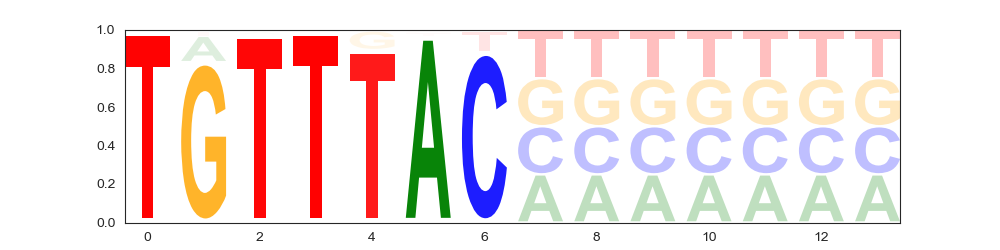

<IPython.core.display.Javascript object>


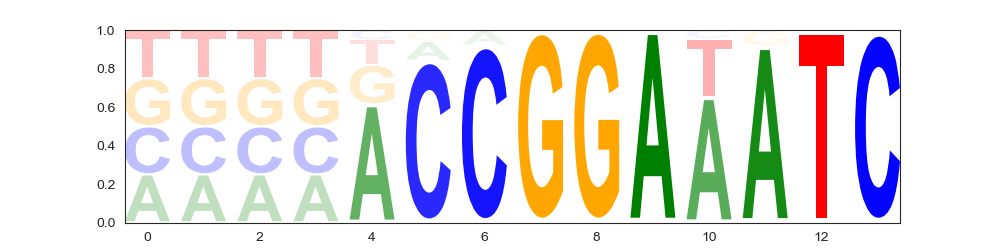

<IPython.core.display.Javascript object>


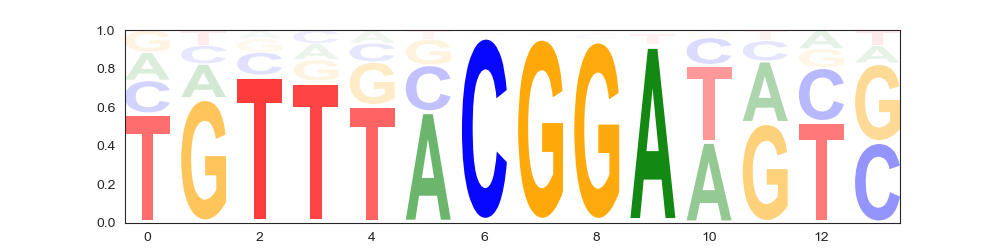

<IPython.core.display.Javascript object>


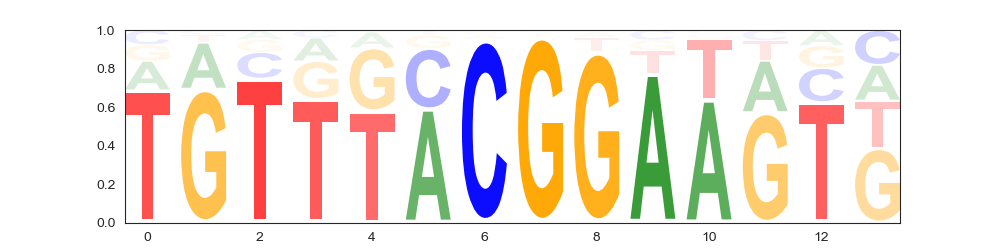

In [83]:
mp_idx = 613
tdimer = 'FLI1_FOXI1_4'
motif1 = possible_mp_code[mp_idx,:,:4]
motif2 = possible_mp_code[mp_idx,:,4:]
tdimer = found_mp_dimer_code[found_mp_name == tdimer][0]
pdimer = pred_dimer[mp_idx].T
for idx, b in enumerate(motif1):
    if sum(b) < 0.3:
        motif1[idx] = np.array([0.25, 0.25, 0.25, 0.25])
for idx, b in enumerate(motif2):
    if sum(b) < 0.3:
        motif2[idx] = np.array([0.25, 0.25, 0.25, 0.25])
for idx, b in enumerate(tdimer):
    if sum(b) < 0.3:
        tdimer[idx] = np.array([0.001, 0.001, 0.001, 0.001])
trim_len = 14
motif1_df = build_df4logmarker(motif1[:trim_len])
logo = logomaker.Logo(motif1_df,
                         width=.8,
                         vpad=.05,
                         fade_probabilities=True,
                         stack_order='small_on_top')
motif2_df = build_df4logmarker(motif2[:trim_len])
logo = logomaker.Logo(motif2_df,
                         width=.8,
                         vpad=.05,
                         fade_probabilities=True,
                         stack_order='small_on_top')
pred_dimer_dimer_df = build_df4logmarker(pdimer[:trim_len])
logo = logomaker.Logo(pred_dimer_dimer_df,
                         width=.8,
                         vpad=.05,
                         fade_probabilities=True,
                         stack_order='small_on_top')

true_dimer_df = build_df4logmarker(tdimer[:trim_len])
logo = logomaker.Logo(true_dimer_df,
                         width=.8,
                         vpad=.05,
                         fade_probabilities=True,
                         stack_order='small_on_top')

In [105]:
A = "0.521447553377842 0.160983717831747 0.110910225661105 0.0858493685584979 0.120947632706712 0.666995679166215 0.420172609649091 0.519575243798434 0.109849187126627 0.177780400856654 0.0587152352474822 0.0206891511338587 0.0322178114085397 0.151456224320943 0.177922829165119 0.169835880181223 0.166704753894768 0.483123325969381 0.20352537655357 0.204329371520208 0.230564736972466 0.203760189414587 0.311738653836837 0.601032856471712 0.833072059666602 0.0877237570826983 0.716282832753528 0.138429805593689"
C = "0.0852752136226182 0.624014418400263 0.815298049912452 0.0729344638524599 0.105088257799699 0.110213204245907 0.128228751327369 0.120207447193221 0.0850401697583639 0.442203308902085 0.848941622716632 0.00948168527321716 0.0374462743710571 0.199677312501221 0.104867366920348 0.100286194661263 0.0988590256983829 0.122411556068116 0.472987548428114 0.319813851467173 0.230165868120047 0.205044660046456 0.23559991584452 0.288774466065415 0.0461273323840406 0.708329970202386 0.0843297150973176 0.297757868156315"
G = "0.238050416506237 0.137216634294536 0.0420607337371725 0.780476358196629 0.685789482585921 0.130093712727756 0.190920985016156 0.236724783332043 0.130392139171102 0.241607932371917 0.0551749228487786 0.834657106489253 0.769275956119587 0.0743721153825768 0.166323787646342 0.171004641918658 0.241798639320848 0.201969223067275 0.203101039697583 0.233967123553148 0.304002751260078 0.232816229507095 0.238973184547496 0.0467361154135376 0.0634734344717449 0.0875209181711886 0.0971464845254381 0.137379141399985"
T = "0.155226816493303 0.0777852294734538 0.0317309906892703 0.0607398093924132 0.0881746269076688 0.092697403860121 0.260677654007384 0.123492525676301 0.674718503943907 0.138408357869345 0.0371682191871071 0.135172057103671 0.161059958100817 0.57449434779526 0.550886016268191 0.558873283238855 0.492637581086001 0.192495894895228 0.120386035320732 0.24188965345947 0.235266643647409 0.358378921031862 0.213688245771147 0.0634565620493361 0.0573271734776121 0.116425354543727 0.102240967623717 0.42643318485001"

<IPython.core.display.Javascript object>


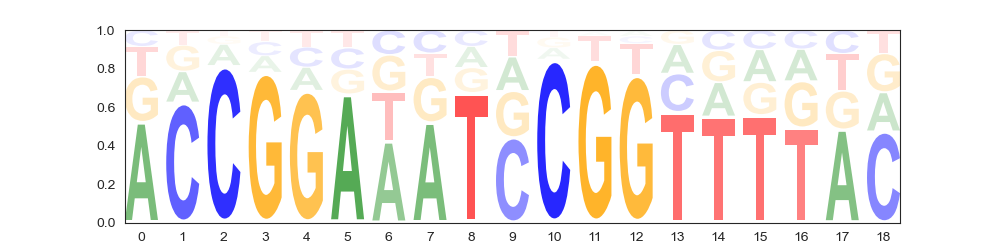

In [106]:
trimed_len = 19
MotifKirin = np.array([[float(i) for i in A.split(" ")],  [float(i) for i in C.split(" ")], [float(i) for i in G.split(" ")], [float(i) for i in T.split(" ")]])
MotifKirin_dimer_df = build_df4logmarker(MotifKirin.T[:trimed_len])
logo = logomaker.Logo(MotifKirin_dimer_df,
                         width=.8,
                         vpad=.05,
                         fade_probabilities=True,
                         stack_order='small_on_top')
logo.ax.set_xticks(range(len(MotifKirin_dimer_df)))
# plt.title('FOXI1')



In [ ]:
MotifKirin = np.array([[float(i) for i in A.split(" ")],  [float(i) for i in C.split(" ")], [float(i) for i in G.split(" ")], [float(i) for i in T.split(" ")]])

<IPython.core.display.Javascript object>


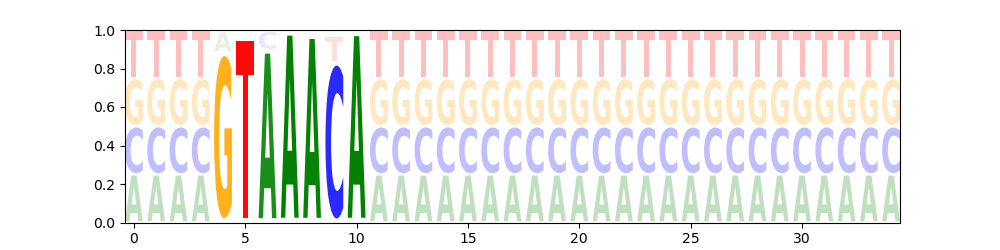

<IPython.core.display.Javascript object>


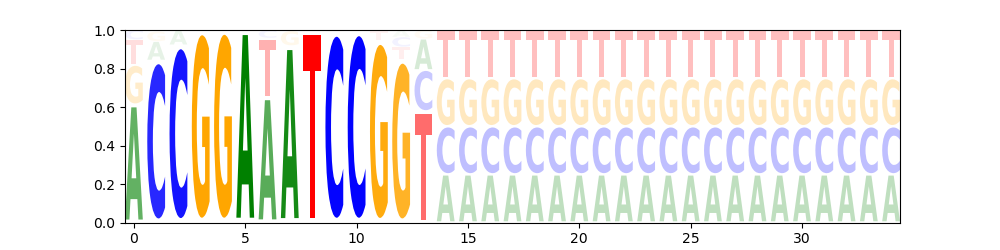

<IPython.core.display.Javascript object>


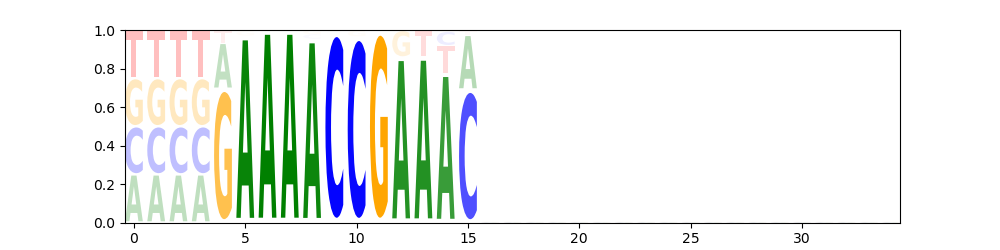

in validate_matrix(): Row sums in df are not close to 1. Reormalizing rows...


In [178]:
# mp_idx = 140003
tdimer = 'FLI1_FOXI1'
motif1 = true_mp_code[found_mp_name == tdimer][0,:,:4]
motif2 = true_mp_code[found_mp_name == tdimer][0,:,4:8]
tdimer = found_mp_dimer_code[found_mp_name == tdimer][0]
for idx, b in enumerate(motif1):
    if sum(b) < 0.3:
        motif1[idx] = np.array([0.25, 0.25, 0.25, 0.25])
for idx, b in enumerate(motif2):
    if sum(b) < 0.3:
        motif2[idx] = np.array([0.25, 0.25, 0.25, 0.25])
for idx, b in enumerate(tdimer):
    if sum(b) < 0.3:
        tdimer[idx] = np.array([0.001, 0.001, 0.001, 0.001])
motif1_df = build_df4logmarker(motif1)
logo = logomaker.Logo(motif1_df,
                         width=.8,
                         vpad=.05,
                         fade_probabilities=True,
                         stack_order='small_on_top')

motif2_df = build_df4logmarker(motif2)
logo = logomaker.Logo(motif2_df,
                         width=.8,
                         vpad=.05,
                         fade_probabilities=True,
                         stack_order='small_on_top')
true_dimer_df = build_df4logmarker(tdimer)
logo = logomaker.Logo(true_dimer_df,
                         width=.8,
                         vpad=.05,
                         fade_probabilities=True,
                         stack_order='small_on_top')